# Performance Estimation of Classification

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>

[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_cls.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1PHd9a4okUQpJ9EtlzTXCT6LIGphfPqUt)

* In this notebook, we will show how to evaluate the performance of classification tasks.
<br>
* We provide the model predicted classification results (network logits) for this tutorial, which will be download automatically. We also provide the model training code in https://github.com/ZerojumpLine/Robust-Skin-Lesion-Classification.
<br>
* More specifically, we show an example of estimating the performance under domain shifts on CIFAR10-LT based on ResNet. We will utilize the calculated logits on test dataset with sythesized motion blur condition.
<br>
* We will calculated model confidence with different confidence scores and varied calibration methods.

In [1]:
!pip install moval
!pip install statannotations
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install seaborn==0.12 # because statannotations not support the latest

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.0
    Uninstalling seaborn-0.12.0:
      Successfully uninstalled seaborn-0.12.0
  Using cached seaborn-0.12.0-py3-none-any.whl (285 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statannotations 0.6.0 requires seaborn<0.12,>=0.9.0, but you have seaborn 0.12.0 which is incompatible.


In [2]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import moval
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
print(f"The installed MOVAL verision is {moval.__version__}")
print(f"The installed seaborn verision is {sns.__version__}")

The installed MOVAL verision is 0.2.11
The installed seaborn verision is 0.12.0


## Load the data

In [4]:
# download the data, which we used for MICCAI 2022

output = "data_moval.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=139pqxkG2ccIFq6qNArnFJWQ2by2Spbxt&export=download"
    output = "data_moval.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [5]:
ls

analysis_cls.ipynb    data_moval_supp.zip   img_cifar/
analysis_seg2d.ipynb  estim_cls.ipynb       img_cifar.zip
analysis_seg3d.ipynb  estim_seg2d.ipynb     img_prostate/
data_moval/           estim_seg3d.ipynb     img_prostate.zip
data_moval.zip        img_cardiac/
data_moval_supp/      img_cardiac.zip


In [6]:
# now I am playing with cifar10 classification
val_data =  "data_moval/cifar10results/predictions_val.csv"
test_data = "data_moval/cifar10results/predictions_val_motion_blur.csv"
# validation data
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4', 
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
# logits is of shape ``(n, d)``
# gt is of shape ``(n, )``

# test data
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4', 
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)

In [7]:
# Here I want to split the test data such that they are not overlapped.
import random
random.seed(79)
test_ind = list(range(10000))
random.shuffle(test_ind)
#
val_ind = test_ind[:3000]
testc_indx_1 = test_ind[3000:]
testc_indx_2 = [x+10000 for x in test_ind[3000:]]
testc_indx_3 = [x+20000 for x in test_ind[3000:]]
testc_indx_4 = [x+30000 for x in test_ind[3000:]]
testc_indx_5 = [x+40000 for x in test_ind[3000:]]
testc_indxs = [testc_indx_1, testc_indx_2, testc_indx_3, testc_indx_4, testc_indx_5]
#

In [8]:
logits_val = logits[val_ind, :]
gt_val = gt[val_ind]
#
logits_tests = []
gt_tests = []
#
for testc_indx in testc_indxs:
    #
    logits_tests.append(logits_test[testc_indx, :])
    gt_tests.append(gt_test[testc_indx])

In [9]:
print(f"The validation predictions, ``logits`` are of shape (n, d), which are now {logits_val.shape}")
print(f"The validation labels, ``gt`` are of shape (n, ), which are now {gt_val.shape}\n")
print(f"The number of test conditions is {len(logits_tests)}")
print(f"The test predictions, ``logits_test`` are of shape (n', d), which are now {logits_tests[0].shape}")
print(f"The test labels, ``gt_test`` are of shape (n', ), which are now {gt_tests[0].shape}")

The validation predictions, ``logits`` are of shape (n, d), which are now (3000, 10)
The validation labels, ``gt`` are of shape (n, ), which are now (3000,)

The number of test conditions is 5
The test predictions, ``logits_test`` are of shape (n', d), which are now (7000, 10)
The test labels, ``gt_test`` are of shape (n', ), which are now (7000,)


## MOVAL estimation on accuracy

In [10]:
moval_options = list(itertools.product(moval.models.get_estim_options(),
                               ["classification"],
                               moval.models.get_conf_options(),
                               [False, True]))

In [11]:
# ac-model does not need class-speicfic variants
for moval_option in moval_options:
    if moval_option[0] == 'ac-model' and moval_option[-1] == True:
        moval_options.remove(moval_option)

In [12]:
print(f"The number of moval options is {len(moval_options)}")

The number of moval options is 36


In [13]:
from moval.solvers.utils import ComputMetric, ComputAUC
from moval.models.utils import cal_softmax

def test_cls(estim_algorithm, mode, metric, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for classification tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        metrc (str): The metric to be estimated.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of shape ``(n, d)`` for classification. 
        gt: The cooresponding annotation of shape ``(n, )`` for classification.
        logits_tests:  A list of m test conditions ``(n', d)``.
        gt_test: The cooresponding annotation of a list of m ``(n', )``.

    Returns:
        err_test: A list of m test err.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                metric = metric,
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    err_tests = []
    for k_test in range(len(logits_tests)):

        _logits_test = logits_tests[k_test]
        _gt_test = gt_tests[k_test]
        
        estim_acc_test = moval_model.estimate(_logits_test)
        
        pred_test = np.argmax(_logits_test, axis = 1)
        if metric == "accuracy":
            
            real_metric = np.sum(_gt_test == pred_test) / len(_gt_test)
        elif metric == "sensitivity":
            real_sensitivities = []
            for kcls in range(_logits_test.shape[1]):
                _, real_sensitivity, _ = ComputMetric(_gt_test == kcls, pred_test == kcls)
                real_sensitivities.append(real_sensitivity)
            real_metric = real_sensitivities
        elif metric == "precision":
            real_precisions = []
            for kcls in range(_logits_test.shape[1]):
                _, _, real_precision = ComputMetric(_gt_test == kcls, pred_test == kcls)
                real_precisions.append(real_precision)
            real_metric = real_precisions
        elif metric == "f1score":
            real_F1scores = []
            for kcls in range(_logits_test.shape[1]):
                real_F1score, _, _ = ComputMetric(_gt_test == kcls, pred_test == kcls)
                real_F1scores.append(real_F1score)
            real_metric = real_F1scores
        else:
            real_auc = ComputAUC(_gt_test, cal_softmax(_logits_test))
            real_metric = real_auc
        
        err_test = np.mean(np.abs(real_metric - estim_acc_test ))
        err_tests.append(err_test)

    return err_tests, moval_model

In [14]:
err_test_list = []
moval_parameters = []
moval_parameters_ = []

In [15]:
for k_cond in tqdm(range(len(moval_options))):
    
    err_test, moval_model = test_cls(
        estim_algorithm = moval_options[k_cond][0], 
        mode = moval_options[k_cond][1], 
        metric = "accuracy",
        confidence_scores = moval_options[k_cond][2],
        class_specific = moval_options[k_cond][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_tests,
        gt_tests = gt_tests
    )
    err_test_list.append(err_test)
    moval_parameters.append(moval_model.model_.param)
    if moval_model.model_.extend_param:
        moval_parameters_.append(moval_model.model_.param_ext)
    else:
        moval_parameters_.append(0.)

  0%|                                                                                                                                                                 | 0/36 [00:00<?, ?it/s]

Starting optimizing for model ac-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Calculating and saving the fitted case-wise performance...


  3%|████▎                                                                                                                                                    | 1/36 [00:00<00:07,  4.80it/s]

Starting optimizing for model ac-model with confidence energy-conf based on metric accuracy, class specific is False.
Calculating and saving the fitted case-wise performance...


  6%|████████▌                                                                                                                                                | 2/36 [00:00<00:07,  4.85it/s]

Starting optimizing for model ac-model with confidence entropy-conf based on metric accuracy, class specific is False.
Calculating and saving the fitted case-wise performance...


  8%|████████████▊                                                                                                                                            | 3/36 [00:00<00:08,  4.08it/s]

Starting optimizing for model ac-model with confidence doctor-conf based on metric accuracy, class specific is False.
Calculating and saving the fitted case-wise performance...


 11%|█████████████████                                                                                                                                        | 4/36 [00:00<00:08,  3.92it/s]

Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 14%|█████████████████████▎                                                                                                                                   | 5/36 [00:01<00:08,  3.80it/s]

Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 17%|█████████████████████████▌                                                                                                                               | 6/36 [00:02<00:21,  1.39it/s]/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/utils.py:39: RuntimeWarning: overflow encountered in exp
  denominator = np.sum(np.exp(x.transpose() / T), axis=0)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:157: RuntimeWarning: invalid value encountered in subtract
  normalized_scores = (scores - self.min_value) / (self.max_value - self.min_value + e1)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  normalized_scores = (scores - self.min_value) / (self.max_value - self.min_value + e1)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:157: RuntimeWarning: invalid value encountered

Starting optimizing for model ts-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Calculating and saving the fitted case-wise performance...


 19%|█████████████████████████████▊                                                                                                                           | 7/36 [00:03<00:19,  1.51it/s]

Starting optimizing for model ts-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Starting optimizing for model ts-model with confidence energy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param for class 0, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Calculating and saving the fitted case-wise performance...


 22%|██████████████████████████████████                                                                                                                       | 8/36 [00:05<00:29,  1.05s/it]

Starting optimizing for model ts-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 25%|██████████████████████████████████████▎                                                                                                                  | 9/36 [00:05<00:22,  1.19it/s]

Starting optimizing for model ts-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confidence entropy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 28%|██████████████████████████████████████████▏                                                                                                             | 10/36 [00:08<00:36,  1.39s/it]

Starting optimizing for model ts-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 31%|██████████████████████████████████████████████▍                                                                                                         | 11/36 [00:08<00:26,  1.06s/it]

Starting optimizing for model ts-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confidence doctor-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 33%|██████████████████████████████████████████████████▋                                                                                                     | 12/36 [00:10<00:31,  1.30s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 36%|██████████████████████████████████████████████████████▉                                                                                                 | 13/36 [00:10<00:22,  1.00it/s]

Starting optimizing for model doc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence max_class_probability-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 39%|███████████████████████████████████████████████████████████                                                                                             | 14/36 [00:11<00:21,  1.01it/s]

Starting optimizing for model doc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 42%|███████████████████████████████████████████████████████████████▎                                                                                        | 15/36 [00:11<00:16,  1.30it/s]

Starting optimizing for model doc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence energy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 44%|███████████████████████████████████████████████████████████████████▌                                                                                    | 16/36 [00:12<00:15,  1.30it/s]

Starting optimizing for model doc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 47%|███████████████████████████████████████████████████████████████████████▊                                                                                | 17/36 [00:13<00:12,  1.52it/s]

Starting optimizing for model doc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence entropy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 18/36 [00:14<00:14,  1.25it/s]

Starting optimizing for model doc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                       | 19/36 [00:14<00:11,  1.49it/s]

Starting optimizing for model doc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence doctor-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 20/36 [00:15<00:12,  1.29it/s]

Starting optimizing for model atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 21/36 [00:15<00:09,  1.60it/s]

Starting optimizing for model atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 61%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 22/36 [00:17<00:10,  1.27it/s]

Starting optimizing for model atc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 23/36 [00:17<00:08,  1.59it/s]

Starting optimizing for model atc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence energy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param for class 8, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 9, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 7, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 6, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 24/36 [00:19<00:14,  1.17s/it]

Starting optimizing for model atc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 25/36 [00:20<00:10,  1.07it/s]

Starting optimizing for model atc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence entropy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 26/36 [00:21<00:10,  1.08s/it]

Starting optimizing for model atc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 27/36 [00:21<00:07,  1.17it/s]

Starting optimizing for model atc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence doctor-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 28/36 [00:23<00:07,  1.04it/s]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 29/36 [00:23<00:05,  1.29it/s]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-atc-model with confidence max_class_probability-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param for class 0, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Calculating and saving the fitted case-wise performance...


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 30/36 [00:26<00:09,  1.50s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Calculating and saving the fitted case-wise performance...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 31/36 [00:27<00:06,  1.25s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Starting optimizing for model ts-atc-model with confidence energy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param for class 0, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 8, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 9, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 time

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 32/36 [00:32<00:10,  2.51s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 33/36 [00:33<00:05,  1.89s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-atc-model with confidence entropy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 34/36 [00:37<00:05,  2.58s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 35/36 [00:37<00:01,  1.93s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-atc-model with confidence doctor-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param for class 0, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Calculating and saving the fitted case-wise performance...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:41<00:00,  1.15s/it]


## Compare estimataion results

In [16]:
estim = []
conf = []
err = []
err_mean = []
novel = []
k_option = 0
for moval_option in moval_options:
    for k_cond in range(len(err_test_list[k_option])):
        #
        if moval_option[3] == True:
            estim_cs = 'CS '
        else:
            estim_cs = ''
        #    
        if moval_option[0] == 'ac-model':
            estim.append(estim_cs + 'AC')
        elif moval_option[0] == 'ts-model':
            estim.append(estim_cs + 'TS')
        elif moval_option[0] == 'doc-model':
            estim.append(estim_cs + 'DoC')
        elif moval_option[0] == 'atc-model':
            estim.append(estim_cs + 'ATC')
        else:
            estim.append(estim_cs + 'TS-ATC')
        #
        if moval_option[2] == 'max_class_probability-conf':
            conf.append('MCP')
        elif moval_option[2] == 'energy-conf':
            conf.append('Energy')
        elif moval_option[2] == 'entropy-conf':
            conf.append('Entropy')
        else:
            conf.append('Doctor')
        #
        if moval_option[2] == 'max_class_probability-conf' and moval_option[3] == False:
            novel.append('Existing Methods')
        else:
            novel.append('Provided by MOVAL')
        #
        err.append(err_test_list[k_option][k_cond])
        err_mean.append(np.mean(err_test_list[k_option]))
    k_option += 1

In [17]:
d = {'Estimation Algorithm': estim, 'Confidence Score': conf, 'MAE': err_mean, 'MAE ': err, 'Category': novel}
df = pd.DataFrame(data=d)
#
custom_order = ['AC', 'TS', 'DoC', 'ATC', 'TS-ATC', 'CS TS', 'CS DoC', 'CS ATC', 'CS TS-ATC']
df['Estimation Algorithm'] = pd.Categorical(df['Estimation Algorithm'], categories=custom_order, ordered=True)
df = df.sort_values(by='Estimation Algorithm')
#
custom_order = ['MCP', 'Doctor', 'Entropy', 'Energy']
df['Confidence Score'] = pd.Categorical(df['Confidence Score'], categories=custom_order, ordered=True)
df = df.sort_values(by='Confidence Score')

In [18]:
df.head()

,Estimation Algorithm,Confidence Score,MAE,MAE,Category
0,AC,MCP,0.401485,0.310355,Existing Methods
25,CS TS,MCP,0.082242,0.047667,Provided by MOVAL
144,TS-ATC,MCP,0.102657,0.129429,Existing Methods
143,TS-ATC,MCP,0.102657,0.119571,Existing Methods
142,TS-ATC,MCP,0.102657,0.107000,Existing Methods


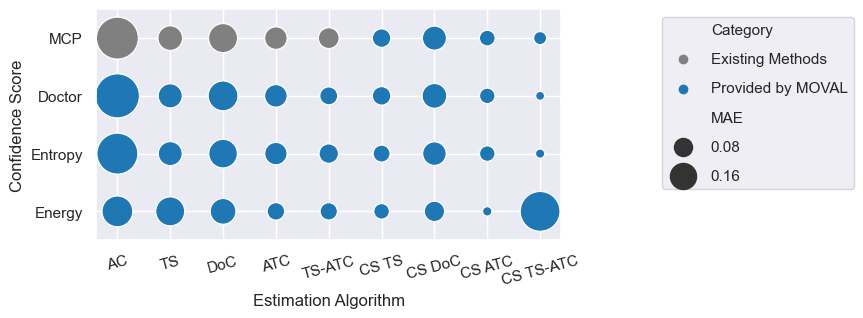

In [19]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set_style("darkgrid")
category_palette = {'Existing Methods': 'grey', 'Provided by MOVAL': '#1f77b4'}
ax = sns.scatterplot(
    data=df, x="Estimation Algorithm", y="Confidence Score", hue="Category", size="MAE",
    sizes=(40, 1000), palette=category_palette
)
ax.set(ylim=(3.5, -0.5))
ax.tick_params(axis='x', rotation=15)
#
# Get the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# Create a custom legend with only desired categories
desired_labels = ['Category', 'Existing Methods', 'Provided by MOVAL', 'MAE', '0.08', '0.16']
desired_handles = [h for h, l in zip(handles, labels) if l in desired_labels]

legend = plt.legend(handles=desired_handles, labels=desired_labels, bbox_to_anchor=(1.2, 1), labelspacing=1)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TS vs. CS TS: Mann-Whitney-Wilcoxon test two-sided, P_val:5.405e-08 U_stat=4.000e+02
DoC vs. CS DoC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.405e-08 U_stat=4.000e+02
ATC vs. CS ATC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.405e-08 U_stat=4.000e+02
TS-ATC vs. CS TS-ATC: Mann-Whitney-Wilcoxon test two-sided, P_val:6.690e-03 U_stat=3.000e+02


(<Axes: xlabel='Estimation Algorithm', ylabel='MAE'>,
  <statannotations.Annotation.Annotation at 0x7fbe6a8fe970>])

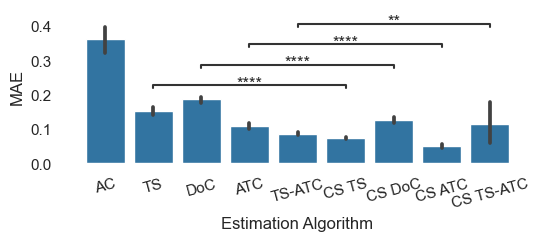

In [20]:
from statannotations.Annotator import Annotator
sns.set(rc={'figure.figsize':(6,2)})
sns.set_style("white")
ax = sns.barplot(df, x="Estimation Algorithm", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
#
pairs=[("TS", "CS TS"), ("DoC", "CS DoC"), ("ATC", "CS ATC"), ("TS-ATC", "CS TS-ATC")]

annotator = Annotator(ax, pairs, data=df, x="Estimation Algorithm", y="MAE")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', text_offset=-4)
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCP vs. Doctor: Mann-Whitney-Wilcoxon test two-sided, P_val:9.227e-01 U_stat=1.000e+03
MCP vs. Entropy: Mann-Whitney-Wilcoxon test two-sided, P_val:2.682e-01 U_stat=1.150e+03
MCP vs. Energy: Mann-Whitney-Wilcoxon test two-sided, P_val:6.163e-01 U_stat=1.075e+03


(<Axes: xlabel='Confidence Score', ylabel='MAE'>,
  <statannotations.Annotation.Annotation at 0x7fbe48b455b0>])

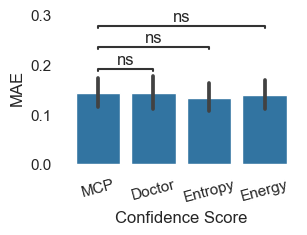

In [21]:
sns.set(rc={'figure.figsize':(3,2)})
sns.set_style("white")
ax = sns.barplot(df, x="Confidence Score", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
#
pairs=[("MCP", "Doctor"), ("MCP", "Entropy"), ("MCP", "Energy")]

annotator = Annotator(ax, pairs, data=df, x="Confidence Score", y="MAE")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATC_MCP vs. CS TS-ATC_Energy: Mann-Whitney-Wilcoxon test two-sided, P_val:3.977e-03 U_stat=0.000e+00


(<Axes: xlabel='Estimation Algorithm', ylabel='MAE '>,
 [<statannotations.Annotation.Annotation at 0x7fbe603ce910>])

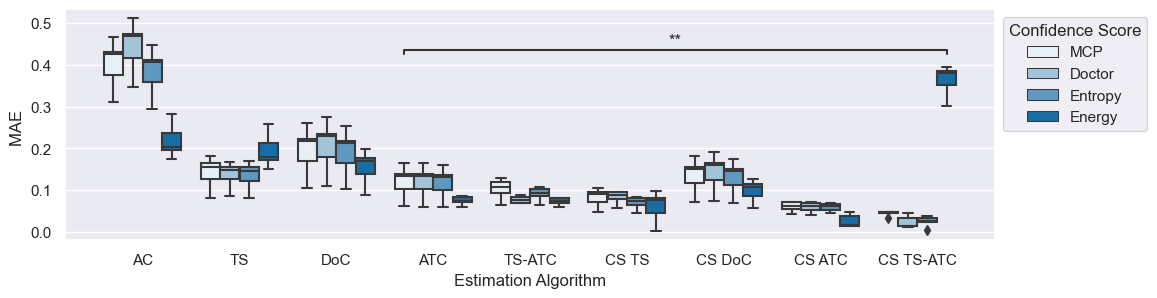

In [22]:
sns.set(rc={'figure.figsize':(12,3)})
category_palette = {'MCP': '#e5f0f8',
                    'Doctor': '#99c6e4',
                    'Entropy': '#4c9cd0',
                    'Energy': '#0072bd'
                   }
ax = sns.boxplot(df, x="Estimation Algorithm", y="MAE ", hue="Confidence Score", palette=category_palette)
ax.set(ylim=(-0.02, 0.5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

pairs=[
    [("ATC", "MCP"), ("CS TS-ATC", "Energy")]
]

annotator = Annotator(ax, pairs, data=df, x="Estimation Algorithm", y="MAE", hue="Confidence Score")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

In [29]:
err_test, moval_model = test_cls(
        estim_algorithm = moval_options[31][0], 
        mode = moval_options[31][1], 
        metric = "accuracy",
        confidence_scores = moval_options[31][2],
        class_specific = moval_options[31][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_tests,
        gt_tests = gt_tests
    )

Starting optimizing for model ts-atc-model with confidence energy-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/5 times.


/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/utils.py:39: RuntimeWarning: overflow encountered in exp
  denominator = np.sum(np.exp(x.transpose() / T), axis=0)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:157: RuntimeWarning: invalid value encountered in subtract
  normalized_scores = (scores - self.min_value) / (self.max_value - self.min_value + e1)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  normalized_scores = (scores - self.min_value) / (self.max_value - self.min_value + e1)
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:157: RuntimeWarning: invalid value encountered in divide
  normalized_scores = (scores - self.min_value) / (self.max_value - self.min_value + e1)


Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Starting optimizing for model ts-atc-model with confidence energy-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param for class 0, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 8, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 9, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 7, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimizatio

In [32]:
moval_model.model_.param

array([3.27423811e-02, 2.13219170e+01, 2.38092633e+01, 1.85556485e+01,
       2.74925744e+01, 2.50896985e+01, 3.10156931e+01, 3.16926453e+01,
       3.29111595e+01, 3.28917068e+01])

In [33]:
moval_model.model_.param_ext

array([0.118125, 0.01    , 0.01    , 0.01    , 0.01    , 0.01    ,
       0.01    , 0.9     , 0.95    , 0.95    ])

## Estimationg of other metrics

In [23]:
test_conditions = moval_options[4:6]

In [24]:
estimatation_metrics = ["accuracy", "sensitivity", "precision", "f1score", "auc"]

In [25]:
err_test_list = []
moval_parameters = []
moval_parameters_ = []

In [26]:
for k_cond in tqdm(range(len(test_conditions))):
    for estimatation_metric in estimatation_metrics:
        err_test, moval_model = test_cls(
            estim_algorithm = test_conditions[k_cond][0], 
            mode = test_conditions[k_cond][1], 
            metric = estimatation_metric,
            confidence_scores = test_conditions[k_cond][2],
            class_specific = test_conditions[k_cond][3],
            logits = logits_val,
            gt = gt_val,
            logits_tests = logits_tests,
            gt_tests = gt_tests
        )
        err_test_list.append(err_test)
        moval_parameters.append(moval_model.model_.param)
        if moval_model.model_.extend_param:
            moval_parameters_.append(moval_model.model_.param_ext)
        else:
            moval_parameters_.append(0.)

  0%|                                                                                                                                                                  | 0/2 [00:00<?, ?it/s]

Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric sensitivity, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric precision, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric

 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 1/2 [00:51<00:51, 51.40s/it]

Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric sensitivity, class specific is True.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confide

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:47<00:00, 53.99s/it]


In [27]:
estim = []
conf = []
metric = []
err = []
err_mean = []
novel = []
k_option = 0
for moval_option in test_conditions:
    for estimatation_metric in estimatation_metrics:
        for k_cond in range(len(err_test_list[k_option])):
            #
            if moval_option[3] == True:
                estim_cs = 'CS '
            else:
                estim_cs = ''
            #    
            if moval_option[0] == 'ac-model':
                estim.append(estim_cs + 'AC')
            elif moval_option[0] == 'ts-model':
                estim.append(estim_cs + 'TS')
            elif moval_option[0] == 'doc-model':
                estim.append(estim_cs + 'DoC')
            elif moval_option[0] == 'atc-model':
                estim.append(estim_cs + 'ATC')
            else:
                estim.append(estim_cs + 'TS-ATC')
            #
            metric.append(estimatation_metric)
            if moval_option[2] == 'max_class_probability-conf':
                conf.append('MCP')
            elif moval_option[2] == 'energy-conf':
                conf.append('Energy')
            elif moval_option[2] == 'entropy-conf':
                conf.append('Entropy')
            else:
                conf.append('Doctor')
            #
            if moval_option[2] == 'max_class_probability-conf' and moval_option[3] == False:
                novel.append('Existing Methods')
            else:
                novel.append('Provided by MOVAL')
            #
            err.append(err_test_list[k_option][k_cond])
            err_mean.append(np.mean(err_test_list[k_option]))
        k_option += 1

In [28]:
d = {'Estimation Algorithm': estim, 'Confidence Score': conf, 'MAE': err_mean, 'MAE ': err, 'Category': novel, 'Metric': metric}
df = pd.DataFrame(data=d)
#
custom_order = ['accuracy', 'sensitivity', 'precision', 'f1score', 'auc']
df['Metric'] = pd.Categorical(df['Metric'], categories=custom_order, ordered=True)
df = df.sort_values(by='Metric')

In [29]:
df

,Estimation Algorithm,Confidence Score,MAE,MAE,Category,Metric
0,TS,MCP,0.141721,0.080761,Existing Methods,accuracy
1,TS,MCP,0.141721,0.125595,Existing Methods,accuracy
2,TS,MCP,0.141721,0.156014,Existing Methods,accuracy
3,TS,MCP,0.141721,0.163744,Existing Methods,accuracy
4,TS,MCP,0.141721,0.182490,Existing Methods,accuracy
28,CS TS,MCP,0.082242,0.095681,Provided by MOVAL,accuracy
27,CS TS,MCP,0.082242,0.089596,Provided by MOVAL,accuracy
26,CS TS,MCP,0.082242,0.072217,Provided by MOVAL,accuracy
25,CS TS,MCP,0.082242,0.047667,Provided by MOVAL,accuracy
29,CS TS,MCP,0.082242,0.106050,Provided by MOVAL,accuracy


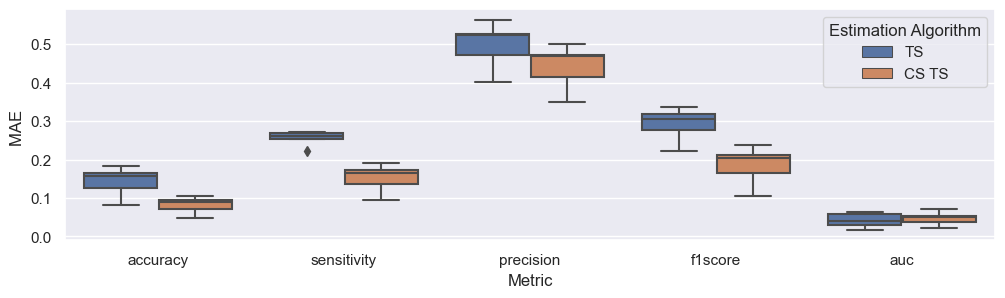

In [30]:
ax = sns.boxplot(df, x="Metric", y="MAE ", hue="Estimation Algorithm")